In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# pdf 문서 읽어오기

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

pdf_loader = PyPDFLoader('./data/proposal.pdf') #  data 폴더 안에 들어있습니다.
pdf_docs = pdf_loader.load()

print(len(pdf_docs)) # number of documents
print()
print(type(pdf_docs)) # list of documents
print()
print(pdf_docs[0]) # document

2

<class 'list'>

page_content='file.md 2025-09-09
1 / 2
프로젝트  개요 : K-Culture 팬  창작자  보상  및  활동  증명 
플랫폼 
1. 프로젝트  비전  (The 'Why')
K-POP 의  성장을  이끄는  숨은  주역인  팬  창작자들의  열정과  기여가  정당한  가치로  인정받는  생태계 를  만듭니 
다 . 우리는  저작권  문제를  지혜롭게  해결하면서 , 이들의  창작  활동이  투명한  보상 과  영구적인  명예 로  이어지는 
새로운  모델을  제시합니다 .
2. 문제  정의와  핵심  해결책 
문제 : 댄스  커버 , 팬아트  등  2 차  창작물은  원저작권  때문에  직접적인  ' 판매 ' 나  ' 수익화 ' 가  불가능합니다 . 이 
로  인해  창작자들의  기여는  정당한  보상으로  이어지지  못하고  휘발되기  쉽습니다 . 또한  K-POP 안무  또한 
저작권으로  보호  되지만 , 음악에  비해서  저작권  인식이  높지  않다 .
핵심  해결책 : ' 판매 ' 가  아닌  ' 시상 (Reward)' 모델 
우리는  저작권이  있는  2 차  창작물을  거래하는  NFT 마켓플레이스를  만들지  않습니다 .
대신 , ' 댄스  경연대회 ' 모델을  적용합니다 . 참가자들이  기존  곡으로  실력을  뽐내고  **' 상금 '** 을  받 
는  것처럼 , 팬  창작자들은  자신의  활동과  인기에  따라  ' 보상  풀 (Reward Pool)' 에  모인  재원 을  받게 
됩니다 .
이  모델을  통해  우리는  저작권  침해  없이 , 창작자의  **' 활동 ' 과  ' 기여 '** 에  대해  보상할  수  있습니다 .
3. ' 보상  풀 ' 의  재원은  어디서  오는가 ? ( 상금의  출처 )
이  상금은  **' 팬덤  활성화 '** 를  목표로  하는  다양한  주체로부터  나옵니다 .
1. 아티스트 / 소속사 : 신곡  홍보 , 챌린지  이벤트  등  마

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200, # 문맥을 살리기 위해서 겹치는 부분 크기
    length_function = len, # 글자 수를 기준 -> 이걸 왜씀? 청크 사이즈 1000이 글자수 1000이 되도록 한다.
    separators = ["\n\n", "\n", " ", ""], # 여러 기준으로 청크 나누기가 가능, 앞에 나오는 것 우선 -> 이게 RecursiveCharacterTextSplitter의 핵심 기능
)

texts = text_splitter.split_documents(pdf_docs) # 위에서 읽은 pdf
print(f"생성된 텍스트 청크 수 : {len(texts)}")
print(f"각 청크의 길이 : {list(len(text.page_content) for text in texts)}")

생성된 텍스트 청크 수 : 3
각 청크의 길이 : [927, 902, 774]


In [282]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model='text-embedding-3-large')

In [283]:
from langchain_chroma import Chroma
# 처음 데이터 생성
# vector_store = Chroma.from_documents(
#     documents=texts,
#     embedding=embeddings_model,
#     collection_name='chroma-req',
#     persist_directory='./chroma-req'
# )

# 데이터 로딩
vector_store = Chroma(
    collection_name='chroma-req',
    embedding_function=embeddings_model,
    persist_directory='./chroma-req'
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})


In [22]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class ReqState(TypedDict):
    req_actor: List[str] # 시스템
    req_names: List[str] # 요구사항명
    req_purpose: List[str]  # 요청목적
    req_importance: List[str] # 중요도
    req_level: List[str] # 난이도
    req_function: List[str] #기능 요구사항
    req_process: List[str] # 프로세스 요구사항
    req_screen: List[str] #화면 요구사항
    req_security: List[str] #보안 요구사항
    req_perform: List[str] # 성능 및 용량 요구사항
    req_data: List[str] # 데이터 요구사항
    query: str       
    context: str     
    answer: str
    

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model="gpt-4o", temperature=0)
# generate_prompt = hub.pull("rlm/rag-prompt") 
actor_prompt = """ 
당신은 뛰어난 IT 프로젝트 기획자, 설계자이다.
주어진 프로젝트 기획서 context를 기반으로 요구분석을 진행하기 위한 사용자 그룹을 정의하라.
사용자 그룹 중 의미의 중복이 발생할 수 있는 사용자 그룹은 공통된 새로운 사용자 그룹을 정리하라.
사용자 그룹은 기획서를 기반으로 진행하라. 또한 실제 서비스 사용시에 발생할 수 있는 사용자 그룹만 정의하라.

예시 : "공통", "관리자", "사용자", "창작자" 등..

context : {context}
"""

generate_prompt = ChatPromptTemplate.from_template(actor_prompt)

In [55]:
from pydantic import BaseModel, Field
from typing import List

class Actor(BaseModel):
    actors : List[str] = Field(description="기획서를 기반으로 요구분석에서 등장할 수 있는 사용자 그룹들")

In [56]:
def generate_actor(state: ReqState) -> ReqState:
    structed_llm = llm.with_structured_output(Actor)
    chain = generate_prompt | structed_llm

    actors = chain.invoke({"context": texts})
    
    print(actors.actors)
    
    return {"req_actor": actors.actors}


In [57]:
init = {"query" : ""}

result = generate_actor(init)

print(result["req_actor"])

['팬 창작자', '일반 팬', '아티스트/소속사', '플랫폼 관리자', '외부 기업/커뮤니티', '저작권자 (안무가, 작곡가, 가수 등)']
['팬 창작자', '일반 팬', '아티스트/소속사', '플랫폼 관리자', '외부 기업/커뮤니티', '저작권자 (안무가, 작곡가, 가수 등)']


In [ ]:
reqirement_prompt = """ 
당신은 뛰어난 IT 프로젝트 기획자, 설계자이다.
주어진 프로젝트 기획서 context와 사용자 그룹 actors를 바탕으로 요구사항 정의를 위한, 요구사항명 목록과 그 요구사항을 필요로 하는 사용자 그룹을 반환하라.
요구사항명은 각 그룹에서 발생할 수 있는 요구사항을 최대한 자세하고, 여러 유스케이스를 포함할 수 있도록 반환하라. 
요구사항명은 사용자가 서비스를 사용하면서 발생할 수 있는 경우들만 작성하라.
반드시 각각의 actors 그룹에서 최소 4개 이상의 요구사항을 반환하라.
요구사항명 뒤에 어떤 사용자 그룹의 요구사항인지 추가로 작성하라. 
이때 반드시 '#'를 구분자로 하여 사용자 그룹을 작성하라.

예시)
요구사항명 : 웹3 지갑을 이용한 회원 인증 (로그인/로그아웃)#공통
요구사항명 : 전역 네비게이션 바 (GNB) 및 푸터#공통
요구사항명 : 팬 콘텐츠 등록#창작자
요구사항명 : 광고 시청을 통한 무료 '응원권' 획득#사용자

context : {context}
actors : {actors}
"""

req_prompt = ChatPromptTemplate.from_template(reqirement_prompt)

In [59]:
class Require(BaseModel):
    names_with_actor : List[str] = Field(description="기획서, 사용자 그룹을 기반으로 나올 수 있는 요구사항명들#사용자 그룹")

In [60]:
def generate_names(state: ReqState) -> ReqState:
    """
    입력:  state["context"], state["req_actor"]
    출력:  {'req_names': <모든 액터의 요구사항명 합집합(중복 제거)>}
    설명:  액터(사용자/관리자/공통)별로 요구사항명을 추출한 뒤,
        전부 합쳐서(중복 제거) req_names에 넣어 반환합니다.
    """
    
    structed_llm = llm.with_structured_output(Require)
    chain = req_prompt | structed_llm
    
    requires = chain.invoke({"context": texts, "actors" : state['req_actor']})

    actors = []
    names = []

    for r in requires.names_with_actor:
        l = r.split("#")
        actors.append(l[1])
        names.append(l[0])
    
    print(actors)
    print(names)
    

    return {"req_actor": actors, "req_names" : names}


In [61]:
result2 = generate_names(result)

print(result2["req_actor"])
print(result2["req_names"])

print(len(result2["req_actor"]))
print(len(result2["req_names"]))

['팬 창작자', '팬 창작자', '팬 창작자', '팬 창작자', '일반 팬', '일반 팬', '일반 팬', '일반 팬', '아티스트/소속사', '아티스트/소속사', '아티스트/소속사', '아티스트/소속사', '플랫폼 관리자', '플랫폼 관리자', '플랫폼 관리자', '플랫폼 관리자', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '저작권자 (안무가, 작곡가, 가수 등)', '저작권자 (안무가, 작곡가, 가수 등)', '저작권자 (안무가, 작곡가, 가수 등)', '저작권자 (안무가, 작곡가, 가수 등)']
['팬 콘텐츠 등록 및 관리', '활동 증명 뱃지 획득', '보상 풀 분배 참여', '팬 창작물에 대한 응원 및 랭킹 시스템 참여', '팬 창작물 응원', '랭킹 시스템 참여', '활동 증명 뱃지 확인', '보상 풀 기여', '신곡 홍보 및 챌린지 이벤트 기획', '팬 창작자와의 협업', '보상 풀 기여', '저작권 관리 및 수익 분배', '플랫폼 내 광고 및 프리미엄 기능 관리', '보상 풀 관리 및 투명성 유지', '팬 창작자 및 팬 활동 모니터링', '기술 스택 및 아키텍처 관리', '스폰서십 및 후원금 제공', '플랫폼 비전 공감 및 협업', '보상 풀 기여', '팬덤 활성화 지원', '저작권 수익 분배 시스템 참여', '저작권 보호 및 관리', '팬 창작물에 대한 저작권 인식 제고', '보상 풀 수익 일부 수령']
['팬 창작자', '팬 창작자', '팬 창작자', '팬 창작자', '일반 팬', '일반 팬', '일반 팬', '일반 팬', '아티스트/소속사', '아티스트/소속사', '아티스트/소속사', '아티스트/소속사', '플랫폼 관리자', '플랫폼 관리자', '플랫폼 관리자', '플랫폼 관리자', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '저작권자 (안무가, 작곡가, 가수 등)', '저작권자 (안무가, 작곡가, 가수 등)', '저작권자 

In [62]:
purpose_prompt = """ 
당신은 뛰어난 IT 프로젝트 기획자, 설계자이다.
프로젝트 기획서의 내용인 context와 요구사항명과 사용자 그룹이 합쳐진 requires 를 기반으로 각 요구사항의 목적을 반환하라.
반드시 **모든** requires에 대해서 1개의 요구사항 목적을 반환하라.

context : {context}
requires : {requires}

반환 예시 ) 
requires : 콘텐츠 및 창작자 검색 기능 -> 반환 : 사용자가 원하는 특정 콘텐츠나 창작자를 쉽게 찾을 수 있도록 하기 위함.
requires : 창작자 프로필 설정 및 관리 -> 반환 : 익명의 지갑 주소 대신, 창작자가 자신을 표현할 수 있는 고유한 프로필(닉네임, 이미지 등)을 설정하여 커뮤니티 내에서 정체성을 가질 수 있도록 하기 위함.


"""

pp_prompt = ChatPromptTemplate.from_template(purpose_prompt)

In [63]:
class Purpose(BaseModel):
    purpose : List[str] = Field(description="각각의 요구사항 명들에 대한 요구사항 목적")

In [64]:
def generate_purpose(state: ReqState) -> ReqState:
    """
    입력:  state["context"], state["req_names"]
    출력:  {'req_purpose': <req_names와 동일 길이의 목적 리스트>}
    설명:  req_names를 배치로 나누어 LLM에 질의, 결과를 순서대로 이어붙임.
    """
    input = [" / ".join([name, actor]) for name, actor in zip(state['req_names'], state['req_actor'])]
    
    structed_llm = llm.with_structured_output(Purpose)
    chain = pp_prompt | structed_llm
    
    purposes = chain.invoke({"context": texts, "requires" : input})

    return {"req_purpose": purposes.purpose}

In [ ]:
result3 = generate_purpose(result2)

KeyError: 'req_names'

In [67]:
print(result3["req_purpose"])
print(len(result3["req_purpose"]))

['팬 창작자들이 자신의 2차 창작물을 체계적으로 관리하고 팬들과 공유할 수 있도록 하기 위함.', '팬 창작자들이 자신의 기여와 업적을 공식적으로 인정받고 기록할 수 있도록 하기 위함.', '팬 창작자들이 자신의 활동에 대한 정당한 보상을 받을 수 있도록 하기 위함.', '팬 창작자들이 자신의 창작물이 팬들로부터 얼마나 인기를 얻고 있는지 파악하고, 이를 통해 보상을 받을 수 있도록 하기 위함.', '일반 팬들이 좋아하는 창작물을 응원함으로써 창작자에게 동기부여를 제공하기 위함.', '일반 팬들이 창작물의 인기도를 실시간으로 확인하고, 이를 통해 창작자에게 보상을 제공하는 데 참여할 수 있도록 하기 위함.', '일반 팬들이 팬 창작자들의 기여와 업적을 확인하고, 그들의 활동을 인정할 수 있도록 하기 위함.', '일반 팬들이 보상 풀에 기여함으로써 팬 창작자들에게 직접적인 지원을 제공할 수 있도록 하기 위함.', '아티스트와 소속사가 신곡을 효과적으로 홍보하고, 팬들과의 상호작용을 통해 팬덤을 활성화할 수 있도록 하기 위함.', '아티스트와 소속사가 팬 창작자들과 협업하여 새로운 콘텐츠를 창출하고, 팬덤을 더욱 강화할 수 있도록 하기 위함.', '아티스트와 소속사가 보상 풀에 기여함으로써 팬 창작자들에게 직접적인 지원을 제공하고, 팬덤을 활성화할 수 있도록 하기 위함.', '아티스트와 소속사가 저작권을 효과적으로 관리하고, 창작자들에게 정당한 수익을 분배할 수 있도록 하기 위함.', '플랫폼 관리자가 플랫폼 내 광고 및 프리미엄 기능을 효과적으로 관리하여 수익을 창출하고, 이를 커뮤니티에 환원할 수 있도록 하기 위함.', '플랫폼 관리자가 보상 풀을 투명하게 관리하여 팬 창작자들에게 공정한 보상을 제공할 수 있도록 하기 위함.', '플랫폼 관리자가 팬 창작자 및 팬의 활동을 모니터링하여 플랫폼의 질을 유지하고, 커뮤니티의 성장을 지원할 수 있도록 하기 위함.', '플랫폼 관리자가 기술 스택 및 아키텍처를 관리하여 플랫폼의 안정성과 성능을 유지할 수 있도록 하기

In [68]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(ReqState)
builder.add_node("generate_actor", generate_actor)                 # 문서 전반 액터(참고)
builder.add_node("generate_names", generate_names)                 # 요구사항명
builder.add_node("generate_purpose", generate_purpose)             # 목적
# builder.add_node("classify_actor_per_item", classify_actor_per_item)  # 항목별 액터 분류(핵심)

builder.add_edge(START, "generate_actor")
builder.add_edge("generate_actor", "generate_names")
builder.add_edge("generate_names", "generate_purpose")
# builder.add_edge("generate_purpose", "classify_actor_per_item")    # 목적 생성 후, 목적+이름 기반으로 액터 분류
builder.add_edge("generate_purpose", END)

graph_mj = builder.compile()

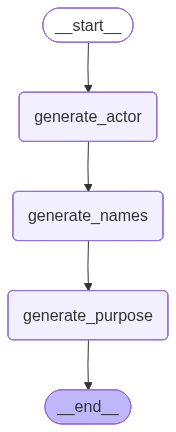

In [69]:
from IPython.display import Image, display

display(Image(graph_mj.get_graph().draw_mermaid_png()))